**Data Analysis and Visualization**

In this section, the results obtained in "model_run" will be analyzed and visualized.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Upload Necessary Data**

In [10]:
# upload the data with the following code
# change the file name to the file you want to load
model_dataframe_initial = pd.read_csv(f"../result_1/{'model_results_no_subsidy'}.csv")
#agent_dataframe_initial = pd.read_csv(f"../result_1/{'agent_results_no_subsidy'}.csv")
print(type(model_dataframe_initial))

model_dataframe_income_threshold = pd.read_csv(f"../result_1/{'model_sensitivity_results_income_threshold'}.csv")
model_dataframe_saving_threshold = pd.read_csv(f"../result_1/{'model_sensitivity_results_saving_threshold'}.csv")
model_dataframe_subsidy_rate = pd.read_csv(f"../result_1/{'model_sensitivity_results_subsidy_rate'}.csv")
model_dataframe_flood_prob = pd.read_csv(f"../result_1/{'model_sensitivity_results_flood_prob'}.csv")
# # Concatenating the dataframes
# merged_dataframe = pd.concat([
#     model_dataframe_income_threshold,
#     model_dataframe_saving_threshold,
#     model_dataframe_subsidy_rate,
#     model_dataframe_flood_prob
# ], ignore_index=True)



<class 'pandas.core.frame.DataFrame'>


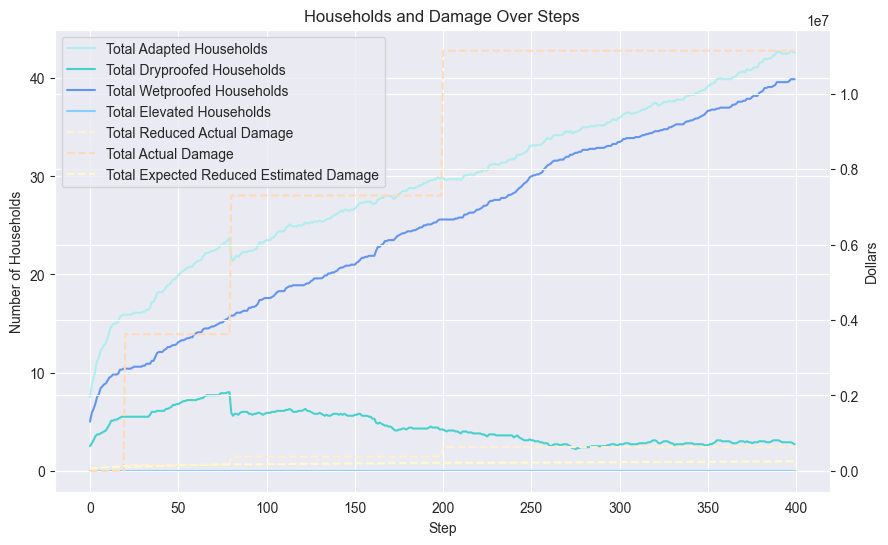

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the grouped_data DataFrame from previous code
grouped_data = model_dataframe_initial.groupby('Step').agg('mean').reset_index()
# Define warm and cold colors
warm_colors = ['PapayaWhip', 'PeachPuff', 'LemonChiffon']
cold_colors = ['PaleTurquoise', 'MediumTurquoise', 'CornflowerBlue', 'LightSkyBlue']

# Create the line chart with dual Y-axes and custom colors
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Lines on the left Y-axis (number of households) with cold colors
ax1.plot(grouped_data['Step'], grouped_data['total_adapted_households'], label='Total Adapted Households', linestyle='-', color=cold_colors[0])
ax1.plot(grouped_data['Step'], grouped_data['total_dryproofed_households'], label='Total Dryproofed Households', linestyle='-', color=cold_colors[1])
ax1.plot(grouped_data['Step'], grouped_data['total_wetproofed_households'], label='Total Wetproofed Households', linestyle='-', color=cold_colors[2])
ax1.plot(grouped_data['Step'], grouped_data['total_elevated_households'], label='Total Elevated Households', linestyle='-', color=cold_colors[3])

# Lines on the right Y-axis (in dollars) with warm colors
ax2.plot(grouped_data['Step'], grouped_data['total_reduced_actual_damage'], label='Total Reduced Actual Damage', linestyle='--', color=warm_colors[0])
ax2.plot(grouped_data['Step'], grouped_data['total_actual_damage'], label='Total Actual Damage', linestyle='--', color=warm_colors[1])
ax2.plot(grouped_data['Step'], grouped_data['total_expected_reduced_estimated_damage'], label='Total Expected Reduced Estimated Damage', linestyle='--', color=warm_colors[2])

# Add labels and title
ax1.set_xlabel('Step')
ax1.set_ylabel('Number of Households')
ax2.set_ylabel('Dollars')
plt.title('Households and Damage Over Steps')

# Show the legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
plt.legend(lines, labels)

# Show the grid
ax1.grid(True)

# Display the chart
plt.show()

In [19]:
import pandas as pd

# Load your DataFrame
model_dataframe_income_threshold = pd.read_csv(f"../result_1/model_sensitivity_results_income_threshold.csv")

# Filter the DataFrame for rows where Step is always 399
filtered_df = model_dataframe_income_threshold[model_dataframe_income_threshold['Step'] == 399]

# Create a list of income_threshold values to loop through
income_thresholds = [3600, 4000, 4400]

# Initialize dictionaries to store results
mean_results = {}
max_results = {}
min_results = {}

# Iterate through income_threshold values
for threshold in income_thresholds:
    # Filter the DataFrame for the specific income_threshold value
    threshold_df = filtered_df[filtered_df['income_threshold'] == threshold]
    
    # Calculate mean, max, and min for total_adapted_households
    mean = threshold_df['total_adapted_households'].mean()
    max_value = threshold_df['total_adapted_households'].max()
    min_value = threshold_df['total_adapted_households'].min()
    
    # Store the results in the dictionaries
    mean_results[threshold] = mean
    max_results[threshold] = max_value
    min_results[threshold] = min_value

# Print the results
for threshold in income_thresholds:
    print(f"For income_threshold = {threshold}:")
    print(f"Mean: {mean_results[threshold]}")
    print(f"Max: {max_results[threshold]}")
    print(f"Min: {min_results[threshold]}")


For income_threshold = 3600:
Mean: 41.2
Max: 52
Min: 32
For income_threshold = 4000:
Mean: 42.6
Max: 53
Min: 35
For income_threshold = 4400:
Mean: 43.6
Max: 53
Min: 36


In [28]:
import pandas as pd

# Load your second DataFrame
model_dataframe_saving_threshold = pd.read_csv("../result_1/model_sensitivity_results_saving_threshold.csv")

# Filter the DataFrame for rows where Step is always 399
filtered_df_saving = model_dataframe_saving_threshold[model_dataframe_saving_threshold['Step'] == 399]

# Create a list of saving_threshold values to loop through
saving_thresholds = [0.45, 0.5, 0.55]

# Initialize dictionaries to store results for the second DataFrame
mean_results_saving = {}
max_results_saving = {}
min_results_saving = {}

# Iterate through saving_threshold values
for threshold in saving_thresholds:
    # Filter the DataFrame for the specific saving_threshold value
    threshold_df_saving = filtered_df_saving[filtered_df_saving['rate'] == threshold]
    
    # Calculate mean, max, and min for total_adapted_households
    mean_saving = threshold_df_saving['total_adapted_households'].mean()
    max_value_saving = threshold_df_saving['total_adapted_households'].max()
    min_value_saving = threshold_df_saving['total_adapted_households'].min()
    
    # Store the results in the dictionaries for the second DataFrame
    mean_results_saving[threshold] = mean_saving
    max_results_saving[threshold] = max_value_saving
    min_results_saving[threshold] = min_value_saving

# Print the results for the second DataFrame
for threshold in saving_thresholds:
    print(f"For saving_threshold = {threshold}:")
    print(f"Mean: {mean_results_saving[threshold]}")
    print(f"Max: {max_results_saving[threshold]}")
    print(f"Min: {min_results_saving[threshold]}")


For saving_threshold = 0.45:
Mean: 52.1
Max: 64
Min: 44
For saving_threshold = 0.5:
Mean: 42.6
Max: 53
Min: 35
For saving_threshold = 0.55:
Mean: 34.4
Max: 46
Min: 27


In [39]:
import pandas as pd

# Load your third DataFrame
model_dataframe_subsidy_rate = pd.read_csv("../result_1/model_sensitivity_results_subsidy_rate.csv")

# Filter the DataFrame for rows where Step is always 399
filtered_df_subsidy = model_dataframe_subsidy_rate[model_dataframe_subsidy_rate['Step'] == 399]

# Create a list of subsidy_rate values to loop through
subsidy_rates = [0.45, 0.5, 0.55]

# Initialize dictionaries to store results for the third DataFrame
mean_results_subsidy = {}
max_results_subsidy = {}
min_results_subsidy = {}

# Iterate through subsidy_rate values
for subsidy_rate in subsidy_rates:
    # Filter the DataFrame for the specific subsidy_rate value
    rate_df_subsidy = filtered_df_subsidy[filtered_df_subsidy['subsidy_rate'] == subsidy_rate]
    
    # Calculate mean, max, and min for total_adapted_households
    mean_subsidy = rate_df_subsidy['total_adapted_households'].mean()
    max_value_subsidy = rate_df_subsidy['total_adapted_households'].max()
    min_value_subsidy = rate_df_subsidy['total_adapted_households'].min()
    
    # Store the results in the dictionaries for the third DataFrame
    mean_results_subsidy[subsidy_rate] = mean_subsidy
    max_results_subsidy[subsidy_rate] = max_value_subsidy
    min_results_subsidy[subsidy_rate] = min_value_subsidy

# Print the results for the third DataFrame
for subsidy_rate in subsidy_rates:
    print(f"For subsidy_rate = {subsidy_rate}:")
    print(f"Mean: {mean_results_subsidy[subsidy_rate]}")
    print(f"Max: {max_results_subsidy[subsidy_rate]}")
    print(f"Min: {min_results_subsidy[subsidy_rate]}")


For subsidy_rate = 0.45:
Mean: 41.5
Max: 52
Min: 32
For subsidy_rate = 0.5:
Mean: 42.6
Max: 53
Min: 35
For subsidy_rate = 0.55:
Mean: 43.2
Max: 55
Min: 35


In [41]:
import pandas as pd

# Load your fourth DataFrame
model_dataframe_flood_prob = pd.read_csv("../result_1/model_sensitivity_results_flood_prob.csv")

# Filter the DataFrame for rows where Step is always 399
filtered_df_flood = model_dataframe_flood_prob[model_dataframe_flood_prob['Step'] == 399]

# Create a list of flood_probabilities values to loop through
flood_probabilities = [0.063, 0.07, 0.077]

# Initialize dictionaries to store results for the fourth DataFrame
mean_results_flood = {}
max_results_flood = {}
min_results_flood = {}

# Iterate through flood_probabilities values
for probability in flood_probabilities:
    # Filter the DataFrame for the specific flood_probabilities value
    probability_df_flood = filtered_df_flood[filtered_df_flood['flood_probability'] == probability]
    
    # Calculate mean, max, and min for total_adapted_households
    mean_flood = probability_df_flood['total_adapted_households'].mean()
    max_value_flood = probability_df_flood['total_adapted_households'].max()
    min_value_flood = probability_df_flood['total_adapted_households'].min()
    
    # Store the results in the dictionaries for the fourth DataFrame
    mean_results_flood[probability] = mean_flood
    max_results_flood[probability] = max_value_flood
    min_results_flood[probability] = min_value_flood

# Print the results for the fourth DataFrame
for probability in flood_probabilities:
    print(f"For flood probability = {probability}:")
    print(f"Mean: {mean_results_flood[probability]}")
    print(f"Max: {max_results_flood[probability]}")
    print(f"Min: {min_results_flood[probability]}")


For flood probability = 0.063:
Mean: 36.9
Max: 45
Min: 29
For flood probability = 0.07:
Mean: 42.6
Max: 53
Min: 35
For flood probability = 0.077:
Mean: 47.9
Max: 61
Min: 37


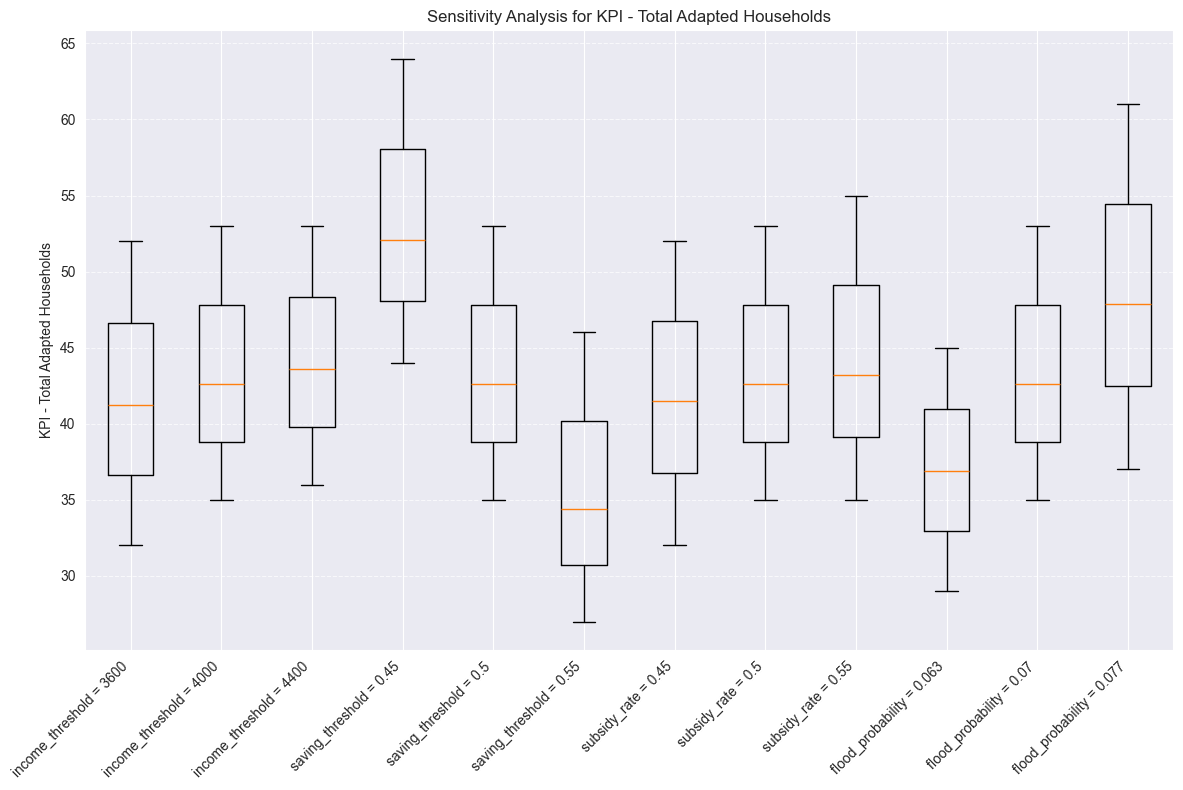

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for all variables
data = {
    'income_threshold': {
        3600: [41.2, 52, 32],
        4000: [42.6, 53, 35],
        4400: [43.6, 53, 36]
    },
    'saving_threshold': {
        0.45: [52.1, 64, 44],
        0.5: [42.6, 53, 35],
        0.55: [34.4, 46, 27]
    },
    'subsidy_rate': {
        0.45: [41.5, 52, 32],
        0.5: [42.6, 53, 35],
        0.55: [43.2, 55, 35]
    },
    'flood_probability': {
        0.063: [36.9, 45, 29],
        0.07: [42.6, 53, 35],
        0.077: [47.9, 61, 37]
    }
}

# Extract data and labels for all variables
variables = ['income_threshold', 'saving_threshold', 'subsidy_rate', 'flood_probability']
all_data = []
all_labels = []

for variable in variables:
    variable_data = data[variable]
    labels = list(variable_data.keys())
    box_data = [variable_data[key] for key in labels]

    all_data.extend(box_data)
    all_labels.extend([f'{variable} = {label}' for label in labels])

# Create the box-whisker chart with variables on the x-axis and KPI on the y-axis
plt.figure(figsize=(12, 8))
plt.boxplot(all_data, labels=all_labels, sym='o', vert=True)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.ylabel('KPI - Total Adapted Households')
plt.title('Sensitivity Analysis for KPI - Total Adapted Households')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


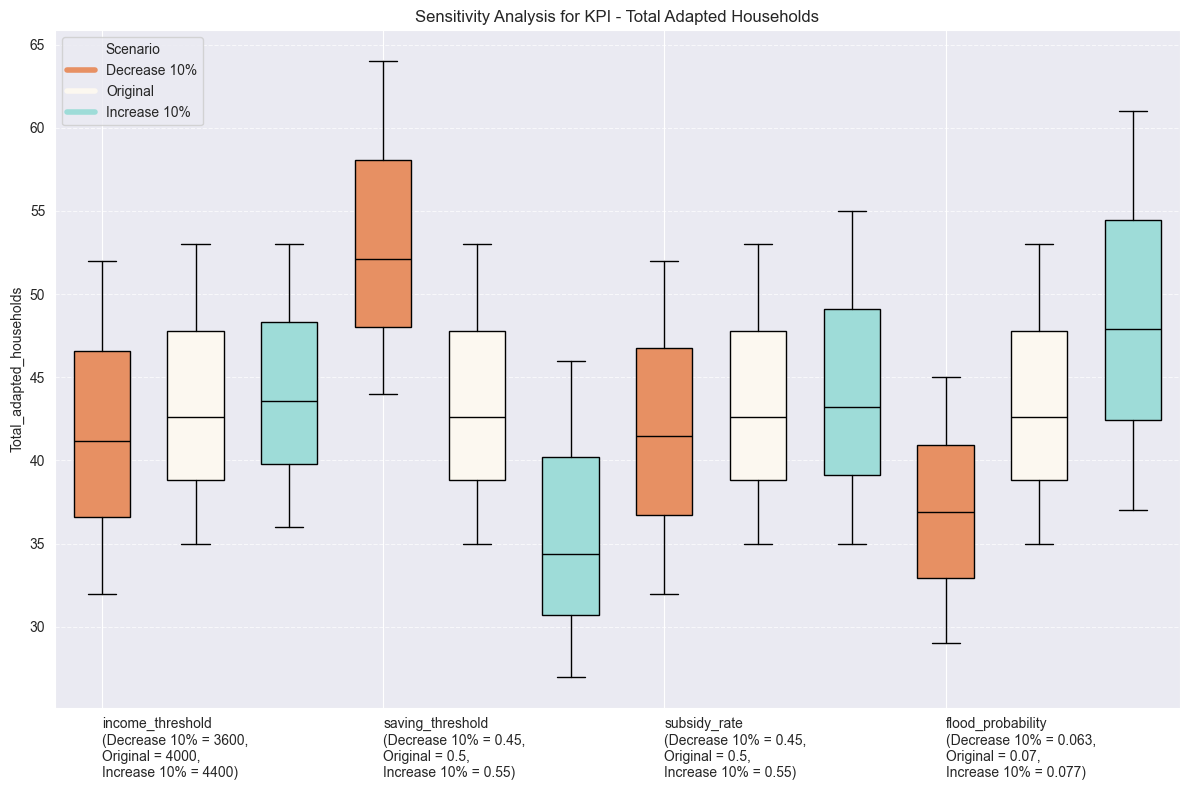

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Define new colors and labels
colors = ['#e79063', '#fcf8f0', '#9edcd8']
scenario_labels = ['Decrease 10%', 'Original', 'Increase 10%']

# Sample data for all variables
data = {
    'income_threshold': {
        3600: [41.2, 52, 32],
        4000: [42.6, 53, 35],
        4400: [43.6, 53, 36]
    },
    'saving_threshold': {
        0.45: [52.1, 64, 44],
        0.5: [42.6, 53, 35],
        0.55: [34.4, 46, 27]
    },
    'subsidy_rate': {
        0.45: [41.5, 52, 32],
        0.5: [42.6, 53, 35],
        0.55: [43.2, 55, 35]
    },
    'flood_probability': {
        0.063: [36.9, 45, 29],
        0.07: [42.6, 53, 35],
        0.077: [47.9, 61, 37]
    }
}

# Create the box-whisker chart
fig, ax = plt.subplots(figsize=(12, 8))
positions = np.array(range(len(data)*len(scenario_labels)))

# Plot each boxplot with a different color
for i, (variable, scenarios) in enumerate(data.items()):
    for j, (level, values) in enumerate(scenarios.items()):
        idx = i*len(scenario_labels) + j
        box = ax.boxplot(values, positions=[positions[idx]], widths=0.6, patch_artist=True, showfliers=True,
                         flierprops=dict(marker='o', color=colors[j], markersize=5))
        plt.setp(box['boxes'], facecolor=colors[j])
        plt.setp(box['whiskers'], color='black')
        plt.setp(box['caps'], color='black')
        plt.setp(box['medians'], color='black')

# Set the labels for the x-ticks
group_labels = [f'{variable}\n({scenario_labels[0]} = {list(scenarios.keys())[0]},'
                f'\nOriginal = {list(scenarios.keys())[1]},'
                f'\n{scenario_labels[2]} = {list(scenarios.keys())[2]})' for variable, scenarios in data.items()]
ax.set_xticks(range(0, len(data)*len(scenario_labels), len(scenario_labels)))
ax.set_xticklabels(group_labels, rotation=0, ha="left")

# Set the axis labels and title
ax.set_ylabel('Total_adapted_households')
ax.set_title('Sensitivity Analysis for KPI - Total Adapted Households')

# Add a custom legend
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, scenario_labels)]
ax.legend(handles=legend_elements, title='Scenario')

# Grid and layout settings
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()



In [51]:
import pandas as pd

# Load your DataFrame
model_dataframe_income_threshold = pd.read_csv(f"../result_1/model_sensitivity_results_income_threshold.csv")

# Filter the DataFrame for rows where Step is always 399
filtered_df = model_dataframe_income_threshold[model_dataframe_income_threshold['Step'] == 399]

# Create a list of income_threshold values to loop through
income_thresholds = [3600, 4000, 4400]

# Initialize dictionaries to store results
mean_results = {}
max_results = {}
min_results = {}

# Iterate through income_threshold values
for threshold in income_thresholds:
    # Filter the DataFrame for the specific income_threshold value
    threshold_df = filtered_df[filtered_df['income_threshold'] == threshold]
    
    # Calculate mean, max, and min for total_expected_reduced_estimated_damage
    mean = threshold_df['total_expected_reduced_estimated_damage'].mean()
    max_value = threshold_df['total_expected_reduced_estimated_damage'].max()
    min_value = threshold_df['total_expected_reduced_estimated_damage'].min()
    
    # Store the results in the dictionaries
    mean_results[threshold] = mean
    max_results[threshold] = max_value
    min_results[threshold] = min_value

# Print the results
for threshold in income_thresholds:
    print(f"For income_threshold = {threshold}:")
    print(f"Mean: {mean_results[threshold]}")
    print(f"Max: {max_results[threshold]}")
    print(f"Min: {min_results[threshold]}")
    
    
# Filter the DataFrame for rows where Step is always 399
filtered_df_saving = model_dataframe_saving_threshold[model_dataframe_saving_threshold['Step'] == 399]

# Create a list of saving_threshold values to loop through
saving_thresholds = [0.45, 0.5, 0.55]

# Initialize dictionaries to store results for the second DataFrame
mean_results_saving = {}
max_results_saving = {}
min_results_saving = {}

# Iterate through saving_threshold values
for threshold in saving_thresholds:
    # Filter the DataFrame for the specific saving_threshold value
    threshold_df_saving = filtered_df_saving[filtered_df_saving['rate'] == threshold]
    
    # Calculate mean, max, and min for total_expected_reduced_estimated_damage
    mean_saving = threshold_df_saving['total_expected_reduced_estimated_damage'].mean()
    max_value_saving = threshold_df_saving['total_expected_reduced_estimated_damage'].max()
    min_value_saving = threshold_df_saving['total_expected_reduced_estimated_damage'].min()
    
    # Store the results in the dictionaries for the second DataFrame
    mean_results_saving[threshold] = mean_saving
    max_results_saving[threshold] = max_value_saving
    min_results_saving[threshold] = min_value_saving

# Print the results for the second DataFrame
for threshold in saving_thresholds:
    print(f"For saving_threshold = {threshold}:")
    print(f"Mean: {mean_results_saving[threshold]}")
    print(f"Max: {max_results_saving[threshold]}")
    print(f"Min: {min_results_saving[threshold]}")
    
# Filter the DataFrame for rows where Step is always 399
filtered_df_subsidy = model_dataframe_subsidy_rate[model_dataframe_subsidy_rate['Step'] == 399]

# Create a list of subsidy_rate values to loop through
subsidy_rates = [0.45, 0.5, 0.55]

# Initialize dictionaries to store results for the third DataFrame
mean_results_subsidy = {}
max_results_subsidy = {}
min_results_subsidy = {}

# Iterate through subsidy_rate values
for subsidy_rate in subsidy_rates:
    # Filter the DataFrame for the specific subsidy_rate value
    rate_df_subsidy = filtered_df_subsidy[filtered_df_subsidy['subsidy_rate'] == subsidy_rate]
    
    # Calculate mean, max, and min for total_expected_reduced_estimated_damage
    mean_subsidy = rate_df_subsidy['total_expected_reduced_estimated_damage'].mean()
    max_value_subsidy = rate_df_subsidy['total_expected_reduced_estimated_damage'].max()
    min_value_subsidy = rate_df_subsidy['total_expected_reduced_estimated_damage'].min()
    
    # Store the results in the dictionaries for the third DataFrame
    mean_results_subsidy[subsidy_rate] = mean_subsidy
    max_results_subsidy[subsidy_rate] = max_value_subsidy
    min_results_subsidy[subsidy_rate] = min_value_subsidy

# Print the results for the third DataFrame
for subsidy_rate in subsidy_rates:
    print(f"For subsidy_rate = {subsidy_rate}:")
    print(f"Mean: {mean_results_subsidy[subsidy_rate]}")
    print(f"Max: {max_results_subsidy[subsidy_rate]}")
    print(f"Min: {min_results_subsidy[subsidy_rate]}")
    
# Filter the DataFrame for rows where Step is always 399
filtered_df_flood = model_dataframe_flood_prob[model_dataframe_flood_prob['Step'] == 399]

# Create a list of flood_probabilities values to loop through
flood_probabilities = [0.063, 0.07, 0.077]

# Initialize dictionaries to store results for the fourth DataFrame
mean_results_flood = {}
max_results_flood = {}
min_results_flood = {}

# Iterate through flood_probabilities values
for probability in flood_probabilities:
    # Filter the DataFrame for the specific flood_probabilities value
    probability_df_flood = filtered_df_flood[filtered_df_flood['flood_probability'] == probability]
    
    # Calculate mean, max, and min for total_expected_reduced_estimated_damage
    mean_flood = probability_df_flood['total_expected_reduced_estimated_damage'].mean()
    max_value_flood = probability_df_flood['total_expected_reduced_estimated_damage'].max()
    min_value_flood = probability_df_flood['total_expected_reduced_estimated_damage'].min()
    
    # Store the results in the dictionaries for the fourth DataFrame
    mean_results_flood[probability] = mean_flood
    max_results_flood[probability] = max_value_flood
    min_results_flood[probability] = min_value_flood

# Print the results for the fourth DataFrame
for probability in flood_probabilities:
    print(f"For flood probability = {probability}:")
    print(f"Mean: {mean_results_flood[probability]}")
    print(f"Max: {max_results_flood[probability]}")
    print(f"Min: {min_results_flood[probability]}")

For income_threshold = 3600:
Mean: 245613.41947046173
Max: 325752.46024446393
Min: 190869.8363302123
For income_threshold = 4000:
Mean: 250209.52705979446
Max: 326952.1882100428
Min: 199998.97183195583
For income_threshold = 4400:
Mean: 253744.35360692703
Max: 328119.7621331632
Min: 204798.8077408618
For saving_threshold = 0.45:
Mean: 357262.2519543209
Max: 449676.4290369182
Min: 287223.84143572394
For saving_threshold = 0.5:
Mean: 250209.52705979446
Max: 326952.1882100428
Min: 199998.97183195583
For saving_threshold = 0.55:
Mean: 175659.04062205518
Max: 239138.92241389464
Min: 135610.1797629109
For subsidy_rate = 0.45:
Mean: 246376.7552839297
Max: 324750.85642252595
Min: 194572.2770195864
For subsidy_rate = 0.5:
Mean: 250209.52705979446
Max: 326952.1882100428
Min: 199998.97183195583
For subsidy_rate = 0.55:
Mean: 253681.8094671174
Max: 332468.6477948232
Min: 200156.81830297672
For flood probability = 0.063:
Mean: 223224.2224608153
Max: 295006.2192316628
Min: 176668.73803389087
For flo

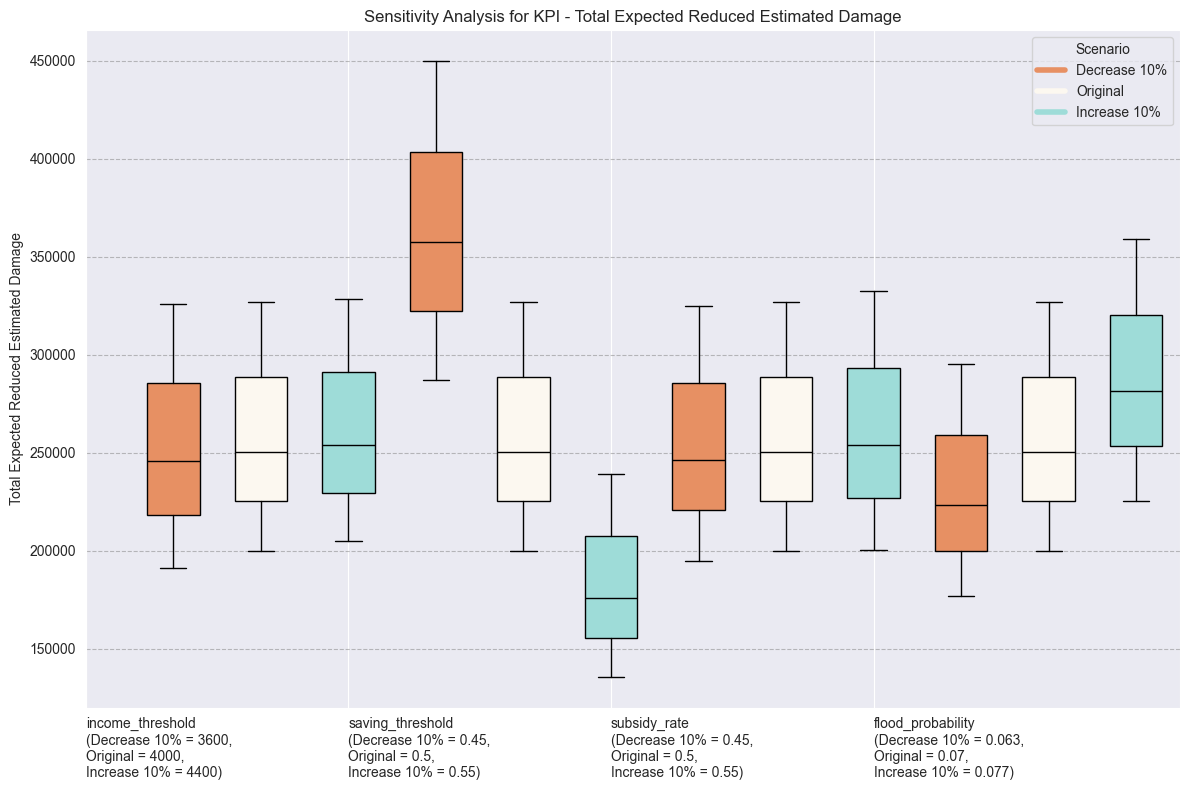

In [63]:
# Correcting the previous code to remove the mean triangle marker and reusing the existing 'plot_data' for simplicity

fig, ax = plt.subplots(figsize=(12, 8))

# Plot each set of data with a different color and label
for i, (box_data, color) in enumerate(zip(plot_data, colors * len(kpi_data))):
    # Calculate position for each boxplot
    position = i + 1
    box = ax.boxplot(box_data, positions=[position], widths=0.6, patch_artist=True,
                     showfliers=True, medianprops=dict(color="black"), showmeans=False)
    plt.setp(box['boxes'], facecolor=color)
    plt.setp(box['whiskers'], color='black')
    plt.setp(box['caps'], color='black')
    plt.setp(box['medians'], color='black')

# Set the labels for the x-ticks
group_labels = [f'{variable}\n({scenario_labels[0]} = {list(scenarios.keys())[0]},'
                f'\nOriginal = {list(scenarios.keys())[1]},'
                f'\n{scenario_labels[2]} = {list(scenarios.keys())[2]})' for variable, scenarios in data.items()]
ax.set_xticks(range(0, len(data)*len(scenario_labels), len(scenario_labels)))
ax.set_xticklabels(group_labels, rotation=0, ha="left")

# Set the y-axis label and title
ax.set_ylabel('Total Expected Reduced Estimated Damage')
ax.set_title('Sensitivity Analysis for KPI - Total Expected Reduced Estimated Damage')

# Add legend for scenarios
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, scenario_labels)]
ax.legend(handles=legend_elements, title='Scenario')

# Grid and tight layout
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

